In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

## Section 1: Generate Data

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define number of time points.
T = 100
C = 2
K = 2

## Define grid space.
nrow = ncol = 20
V = nrow * ncol

## Define latent sources.
loc = [[2.5,2.5],[7.5,7.5]]
ext = [2.5, 2.5]

## Define noise.
sigma = 0.1

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Define grid.
R = np.array(np.meshgrid(np.arange(nrow), np.arange(ncol))).T
R = R.reshape(V, 2)

## Define along [0,1].
R = np.divide(R, R.max(axis=0)) * 10

## Define design matrix.
X = np.zeros((T, 2), dtype=float)
X[:T//2, 0] = 1
X[T//2:, 1] = 1

## Define weight matrix.
W = np.identity(2)
    
## Define basis image matrix.
F = np.zeros((K, V))
for i in np.arange(K):
    F[i] = np.exp( -np.linalg.norm(R - loc[i], axis=-1) ** 2 / ext[i] )
    
Y = X @ W @ F + np.random.normal(loc=0, scale=sigma, size=(T,V))

## Section 2: Stan Testing

In [3]:
import pystan

TLSA = pystan.StanModel('stan_models/TLSA.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8f554538d9922348dcbb3dd746b75b96 NOW.


In [36]:
## Define metadata.
T, V = Y.shape
T, K = X.shape
V, D = R.shape
Z = 2
loc_pr = loc

data = dict(T=T, V=V, K=K, Z=Z, D=D, Y=Y, X=X, R=R, loc_pr=loc_pr)

In [37]:
fit = TLSA.sampling(data=data, chains=2, iter=1000, seed=47404, n_jobs=4)

/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [38]:
fit

Inference for Stan model: anon_model_8f554538d9922348dcbb3dd746b75b96.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
W[0]       0.98  2.5e-4 7.9e-3   0.97   0.97   0.98   0.99    1.0   1000    1.0
W[1]     7.3e-4  1.2e-4 3.6e-3-6.6e-3-1.6e-3 7.9e-4 3.3e-3 7.9e-3   1000    1.0
W[2]     1.9e-3  1.2e-4 3.8e-3-5.7e-3-5.7e-4 1.9e-3 4.4e-3 9.6e-3   1000    1.0
W[3]        1.0  3.8e-4 7.5e-3   0.99    1.0    1.0   1.01   1.02    395   1.01
sigma       0.1  1.1e-5 3.5e-4    0.1    0.1    0.1    0.1    0.1   1000    nan
loc[0,0]    2.5  1.8e-4 5.8e-3   2.49   2.49    2.5    2.5   2.51   1000    1.0
loc[1,0]    7.5  1.8e-4 5.7e-3   7.48   7.49    7.5    7.5   7.51   1000    1.0
loc[0,1]    2.5  1.9e-4 5.9e-3   2.49    2.5    2.5   2.51   2.52   1000    1.0
loc[1,1]   7.49  1.9e-4 6.0e-3   7.48   7.49   7.49    7.5    7.5   1000    1.0
fwhm[0]    1.

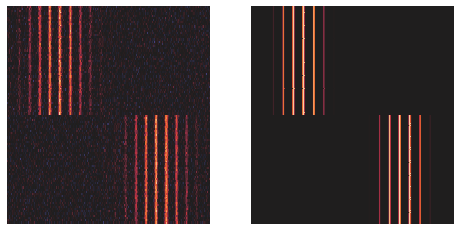

In [41]:
params = fit.extract()
W = np.median(params['W'].reshape(-1, 2, Z), axis=0)
fwhm = np.median(params['fwhm'], axis=0)
scale = np.median(params['scale'], axis=0)
loc_hat = np.median(params['loc'], axis=0)

Fhat = np.zeros((Z, V))
for i in np.arange(Z):
    f = np.linalg.norm(R - loc_hat[i], axis=-1) ** 2
    Fhat[i] = 1 / (1 + np.exp( (f - fwhm[i]) / scale[i]  ))
    
Yhat = X @ W @ Fhat

fig, axes = plt.subplots(1,2,figsize=(8,4))
sns.heatmap(Y, center=0, cbar=False, xticklabels=[], yticklabels=[], ax=axes[0])
sns.heatmap(Yhat, center=0, cbar=False, xticklabels=[], yticklabels=[], ax=axes[1])